# Rootzone Soil Water from Surface Observations

Soil water stress is considered a major yield limiting factor affecting summer crops. Monitoring soil moisture along the entire rootzone during the crop season can be useful to inform irrigation decisions and maximize yields, but while soil moisture sensors can be deployed at multiple soil depths, this process can laborious and expensive for producers and irrigation managers.

What if we could only deploy a single soil moisture sensor near the soil surface and we use the information from this information to infer the storage of the entire profile? The top layer is the layer that exhibitis the largest and sudden soil moisture changes, so if we capture these dynamics, then we might be able to propagate those changes along the profile.

The exponential filter is a method widely used to predict rootzone soil water content from time series of surface soil moisture observations originally proposed by Wagner et al. (1999) and later refined by Albergel et al. (2008) in terms of a recursive method. The method consists of subdiving the soil profile into two layers, a surface layer (the layer that we monitor) and a sub-surface layer (the layer tha we don't monitor). The method assumes that the amount of soil water that moves from the t to the sub-surface layer is propertional to the difference in soil moisture between the layers .  

Here is what the filter looks like:

$$ SWI_t = SWI_{t-1} + \; K_t (\theta_t - SWI_{t-1}) $$  

$$ K_t = \frac{K_{t-1}} { K_{t-1} + e^{- \frac{\Delta t}{T} } } $$


$SWI_t$ is the soil water index in dimensionless arbitrary units. At the end of the filter we need to rescale the $SWI$ based on sound lower and upper soil moisture values for the soil in question. 

$K_t$ is a time variant gain of the exponential filter or proportionality parameter that ranges between 0 and 1.

$\theta$ is the volumetric water content measured by the sensor near the soil surface in cm$^3$/cm$^3$

$\Delta t$ is the time between observations. In our case we are dealing with hourly observations and no missing values, so $\Delta t = 1/24$ days. Because dataloggers also record the timestamp of the measurements, we will leverage this to determine in each step the value of $\Delta t$. The value won't change in our case, but hopefully would be enough to get you started processing your own regularly or irreguarly temporally-spaced data.

$T$ is a parameter denoting the timescale of soil moisture variation in days. This constant parameter plays an important role smoothing the signal. In the code below, feel free to play with this parameter to see the impact on the soil moisture dynamics.

The model is initialized assuming $K=1$ and $SWI_{t_0} = \theta_{t_0}$. At the end of the recursive filter the $SWI$ needs to be rescaled to obtain the profile soil water content. We will do this in the last line of our exponential filter function.


## Dataset

For this example, hourly soil moisture observations at 10 cm depth from an actual corn field from July to September near the town of Moundridge, KS will be used to test the ability of the exponential filter to predict profile soil moisture content from surface observations. The sensors were located at 10, 30, 50, and 70 cm depth. We assume that each sensor is located at the center of each layer. For instance, the sensor at 10 cm depth is at the center of the 0-20 cm layer. So, we will use the soil moisture of a given sensor as the average for the entire layer at the time of computing the storage of the profile (sum of the storage of all four layers). We will only use the sensor at 10 cm to drive our filter and we will use the known soil moisture at all four depths to validate the performance of the exponential filter.


In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


## Load and inspect data

In [2]:
# Load data
df = pd.read_csv("../datasets/soil_moisture_corn_moundridge_ks.csv")
df.head()


,TIMESTAMP,RECORD,VWC10CM,VWC30CM,VWC50CM,VWC70CM
0,7/8/19 6:00,1788,0.408,0.512,0.507,0.484
1,7/8/19 7:00,1789,0.408,0.512,0.507,0.484
2,7/8/19 8:00,1790,0.408,0.512,0.506,0.484
3,7/8/19 9:00,1791,0.407,0.511,0.506,0.484
4,7/8/19 10:00,1792,0.406,0.511,0.506,0.484


In [3]:
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"], format="%m/%d/%y %H:%M")
df.head()


,TIMESTAMP,RECORD,VWC10CM,VWC30CM,VWC50CM,VWC70CM
0,2019-07-08 06:00:00,1788,0.408,0.512,0.507,0.484
1,2019-07-08 07:00:00,1789,0.408,0.512,0.507,0.484
2,2019-07-08 08:00:00,1790,0.408,0.512,0.506,0.484
3,2019-07-08 09:00:00,1791,0.407,0.511,0.506,0.484
4,2019-07-08 10:00:00,1792,0.406,0.511,0.506,0.484


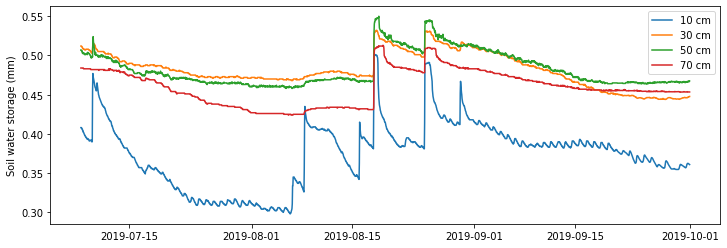

In [4]:
# Generate plot to inspect data
plt.figure(figsize=(12,4))
plt.plot(df["TIMESTAMP"], df["VWC10CM"], label='10 cm')
plt.plot(df["TIMESTAMP"], df["VWC30CM"] ,label='30 cm')
plt.plot(df["TIMESTAMP"], df["VWC50CM"] ,label='50 cm')
plt.plot(df["TIMESTAMP"], df["VWC70CM"] ,label='70 cm')
plt.ylabel("Soil water storage (mm)")
plt.legend()
plt.show()


In [5]:
# Compute ground-truth using the trapezoidal rule to check predictions from our model
SWC_obs = np.trapz(df.loc[:,["VWC10CM","VWC30CM","VWC50CM","VWC70CM"]], 
                   x=[100,300,500,700])


## Define recursive exponential filter

In [6]:
def expfilter(timestamp,vwc,mx,mn,T=1):
    """"
    Calculates profile soil water content from surface observations.
    
    Inputs
    - timestamp: Date and time in pandas datetime format
    - vwc: observed volumetric water content at the surface layer in cm^3/cm^3
    - mx: maximum profile storage in mm
    - mn: minimum profile storage in mm
    - T: timescale parameter of soil moisture variation in days
    
    Outputs:
    - SWC : Profile soil water content in millimeters
    
    Author: Pedro Rossini on 16-Apr-2019
    Updated by Andres Patrignani on 14-Mar-2020
    """

    # Pre-allocate arrays
    N = len(vwc)
    SWI = np.ones(N) * np.nan
    K = np.ones(N) * np.nan
    
    # Compute soil water index of top layer
    SWI[0] = vwc[0]

    # Initialize gain
    K[0] = 1
    
    for t in range(1,N):
        
        # Update gain
        t_delta = (timestamp[t] - timestamp[t-1]).total_seconds()/86400 # in days
        K[t] = K[t-1]/(K[t-1] + np.exp(-t_delta/T))
        
        # Update soil water index
        SWI[t] = SWI[t-1] + K[t] * (vwc[t] - SWI[t-1])
  
    # Rescale SWI into SWC
    SWC = (mx - mn) / (np.max(SWI) - np.min(SWI)) * (SWI - np.max(SWI)) + mx
    
    return SWC

## Run filter with guessed parameters

It's always fun when running model to try to guess parameter values based on your existing knowledge about the field and state of the system. To me this is a learning moment where I can test whether I truly understand the system I'm trying to model. We will use some values based on what we know from soil physics and the plot we created above.


In [7]:
# Run filter using guessed paramenters
timestamp =  df["TIMESTAMP"]
vwc = df["VWC10CM"]
SWC_guessed = expfilter(timestamp, vwc, mx=320, mn=250, T=1)


In [8]:
# Compute error between observed and model with guessed parameters
RMSE_guessed = np.sqrt(np.mean((SWC_obs - SWC_guessed)**2))
print('Error with guessed parameters:',round(RMSE_guessed), 'mm')


Error with guessed parameters: 13.0 mm


## Optimize filter parameters

In [9]:
# Define model as a lambda function, where x is vwc
model = lambda x,a,b,c: expfilter(timestamp,x,a,b,c)
lb = [200,0,0] # Plausible lower boundaries
ub = [400,300,100] # Plausible upper boundaries

# This part may take few seconds when working with large datasets
par_opt, par_cov = curve_fit(model, vwc, SWC_obs, bounds=(lb, ub))
print(par_opt)


[3.10793610e+02 2.54899780e+02 1.48210359e-01]


In [10]:
# Estimate profile soil moisture using optimized parameters
SWC_opt = model(vwc, *par_opt)


In [11]:
# Compute error between observed and model with optimized parameters
RMSE_opt = np.sqrt(np.mean((SWC_obs - SWC_opt)**2))
print('Error with optimized parameters:', round(RMSE_opt), 'mm')


Error with optimized parameters: 7.0 mm


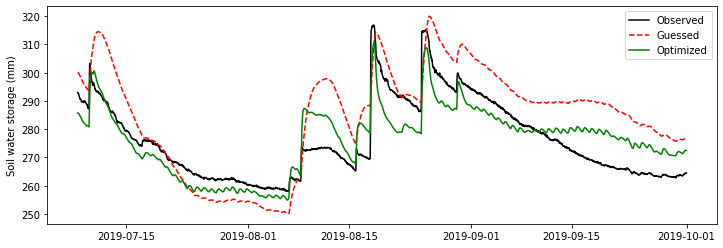

In [12]:
# Plot observations and model
plt.figure(figsize=(12,4))
plt.plot(df["TIMESTAMP"], SWC_obs, '-k',label='Observed')
plt.plot(df["TIMESTAMP"], SWC_guessed, '--r', label='Guessed')
plt.plot(df["TIMESTAMP"], SWC_opt, '-g', label="Optimized")
plt.ylabel("Soil water storage (mm)")
plt.legend()
plt.show()


## Comments

- The model successfully mimicked the profile soil moisture dynamics and estimated the profile soil water content with an error of about 10 mm.

- The model was able to capture the soil moisture response to rainfall and irrigation events during the growing season.

- The error of the exponential filter is about 10 mm, which is excellent considering the range in profile soil water content.

- Guessing the parameters based on knowledge of soil physics and existing data resulted in fairly good approximation. The exponential filter strongly relies on accurate minimum and maximum threshold values of profile storage to accurate rescale the soil water index into soil water storage. 


## References

Albergel, C., Rudiger, C., Pellarin, T., Calvet, J.-C., Fritz, N., Frois-sard, F., Suquia, D., Petitpa, A., Piguet, B., and Martin, E.(2008) From near-surface to root-zone soil moisture using an exponential filter: an assessment of the method based on in-situ observations and model simulations, Hydrol. Earth Syst. Sci., 12, 1323–1337,
doi:10.5194/hess-12-1323-2008

Tobin, K.J., Torres, R., Crow, W.T. and Bennett, M.E., 2017. Multi-decadal analysis of root-zone soil moisture applying the exponential filter across CONUS. Hydrology & Earth System Sciences, 21(9).

Wagner, W., Lemoine, G., & Rott, H. (1999). A method for estimating soil moisture from ERS scatterometer and soil data. Remote sensing of environment, 70(2), 191-207.
